In [26]:
import folium 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import compose, pipeline, impute
from sklearn.preprocessing import StandardScaler, TargetEncoder, MinMaxScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv('final.csv')
df

TYPE      PRICE  BEDS  BATH  PROPERTYSQFT         LOCALITY  \
0     Condo   315000.0     2     2   1400.000000         New York   
1     Condo   522000.0     7     2   2273.324717         New York   
2     Condo    69000.0     3     1    445.000000         New York   
3     House   690000.0     5     2   2133.124717         New York   
4     Condo   899500.0     2     2   2184.207862  New York County   
...     ...        ...   ...   ...           ...              ...   
4131  Co-op   599000.0     1     1   2184.207862  New York County   
4132  Co-op   245000.0     1     1   2184.207862         New York   
4133  Co-op  1275000.0     1     1   2184.207862         New York   
4134  Condo   598125.0     2     1    655.000000    Queens County   
4135  Co-op   349000.0     1     1    750.000000     Kings County   

          SUBLOCALITY       STREET_NAME         LONG_NAME   LATITUDE  ...  \
0           Manhattan  East 55th Street   Regis Residence  40.761255  ...   
1     New York County          New York  West 57th Street  40.766393  ...   
2     New York County          New York  East 55th Street  40.761398  ...   
3        Kings County          Brooklyn        Park Place  40.674363  ...   
4            New York         Manhattan               157  40.809448  ...   
...               ...               ...               ...        ...  ...   
4131         New York         Manhattan               222  40.774350  ...   
4132    Queens County            Queens        62nd Drive  40.732538  ...   
4133  New York County          New York  West 21st Street  40.745882  ...   
4134           Queens          Flushing             91-23  40.742770  ...   
4135         Brooklyn      Coney Island               460  40.579147  ...   

                                       SUBWAY_STATION     DISTANCE  \
0        6th Avenue & 56th Street at Southeast Corner   361.441253   
1        6th Avenue & 57th Street at Southwest Corner   384.829887   
2        6th Avenue & 56th Street at Southeast Corner   342.844227   
3                   Eastern Parkway - Brooklyn Museum   518.648971   
4     Lenox Avenue & 125th Street at Northwest Corner   192.796697   
...                                               ...          ...   
4131     83rd Street & 2nd Avenue at Northeast Corner   319.462087   
4132                                      67th Avenue   840.621152   
4133                              Moynihan Train Hall   885.320508   
4134                                  Elmhurst Avenue   741.950989   
4135                          Bay Parkway & 66 Street  3875.186999   

      KINDERGARTEN  SCHOOL  COLLEGE   CAFE    BAR  PARKING  SUPERMARKET  \
0              6.0    42.0      6.0  353.0  122.0     57.0         54.0   
1              3.0    41.0      4.0  327.0  120.0     44.0         46.0   
2              6.0    41.0      6.0  355.0  122.0     57.0         54.0   
3             33.0    32.0      1.0  142.0   82.0      5.0         48.0   
4              4.0    68.0      2.0   65.0   19.0      2.0         38.0   
...            ...     ...      ...    ...    ...      ...          ...   
4131           3.0    43.0      1.0  154.0   59.0     14.0         42.0   
4132           2.0     6.0      0.0   23.0    4.0     24.0         24.0   
4133           5.0    29.0      6.0  312.0  177.0     21.0         51.0   
4134           2.0    10.0      0.0   28.0   16.0      9.0         42.0   
4135           2.0     5.0      0.0   17.0    8.0      4.0         11.0   

      ZIP_CODE  
0        10022  
1        10019  
2        10022  
3        11238  
4        10027  
...        ...  
4131     10075  
4132     11374  
4133     10011  
4134     11373  
4135     11224  

[4136 rows x 21 columns]

In [28]:
df.SUBWAY_STATION.describe()

count                        4136
unique                        164
top       Bay Parkway & 66 Street
freq                          706
Name: SUBWAY_STATION, dtype: object

In [29]:
df.dtypes

TYPE               object
PRICE             float64
BEDS                int64
BATH                int64
PROPERTYSQFT      float64
LOCALITY           object
SUBLOCALITY        object
STREET_NAME        object
LONG_NAME          object
LATITUDE          float64
LONGITUDE         float64
SUBWAY_STATION     object
DISTANCE          float64
KINDERGARTEN      float64
SCHOOL            float64
COLLEGE           float64
CAFE              float64
BAR               float64
PARKING           float64
SUPERMARKET       float64
ZIP_CODE            int64
dtype: object

In [30]:
# Нормализуем цену для создания цветового градиента
price_min, price_max = df['PRICE'].min(), df['PRICE'].max()
map_center = [df['LATITUDE'].mean(), df['LONGITUDE'].mean()]

# Функция для интерполяции цвета
def price_to_color(price, cmap=plt.cm.viridis):
    norm_price = (price - price_min) / (price_max - price_min)  # Нормализация цены
    rgba_color = cmap(norm_price)  # Получаем RGBA из colormap
    return f'rgba({int(rgba_color[0]*255)}, {int(rgba_color[1]*255)}, {int(rgba_color[2]*255)}, {rgba_color[3]:.2f})'

# Создаем новую карту
nyc_map_gradient = folium.Map(location=map_center, zoom_start=12)

# Добавляем маркеры с градиентом цвета
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row['LATITUDE'], row['LONGITUDE']),
        radius=5,
        color=price_to_color(row['PRICE']),
        fill=True,
        fill_opacity=0.7,
        popup=f"Price: ${row['PRICE']:,.2f}",
    ).add_to(nyc_map_gradient)
nyc_map_gradient

In [31]:
categorical_preprocessing = compose.make_column_transformer(
    (
        pipeline.make_pipeline(
            impute.SimpleImputer(
                strategy="most_frequent",
            ),
            TargetEncoder(
                smooth='auto',
                target_type="continuous",
            ),
            StandardScaler()
        ),
        compose.make_column_selector(
            dtype_include=object,
        )
    ),
    n_jobs=-1,
    remainder="drop"
)
numerical_preprocessing = compose.make_column_transformer(
    (
        pipeline.make_pipeline(
            impute.SimpleImputer(
                strategy="mean"
            ),
            StandardScaler(
                with_mean=True,
                with_std=True
            )
        ),
        compose.make_column_selector(
            dtype_include=np.number,
        ),    
    ),
    n_jobs=-1,
    remainder="drop"
)

int_preprocess = compose.make_column_transformer(
    (
        pipeline.make_pipeline(
            impute.SimpleImputer(
                strategy='mean'
            ),
            MinMaxScaler()
        ),
        compose.make_column_selector(dtype_include=np.int64)
    ),
    n_jobs=-1,
    remainder=numerical_preprocessing
)
transforms = pipeline.make_union(
    categorical_preprocessing,
    int_preprocess
)

In [32]:
X = df.loc[:, df.columns != 'PRICE']
y = df.loc[:, 'PRICE']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [34]:
X_train = transforms.fit_transform(X=X_train, y=y_train)

In [35]:
import torch
from torch import nn
import torch.functional as F
from torch.optim import Adam
from tqdm.autonotebook import tqdm

C:\Users\kuzin\AppData\Local\Temp\ipykernel_30628\207211943.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [36]:
model = nn.Sequential(
    nn.LazyLinear(out_features=512),
    nn.LeakyReLU(),
    nn.Linear(512, 512),
    nn.LeakyReLU(),
    nn.Linear(512, 1)
)
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
criterion = nn.MSELoss()

In [37]:
def train_loop(model, optimizer, criterion, num_steps):
    model.train()
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.log1p(torch.FloatTensor(y_train).unsqueeze(1))
    x_for_test = transforms.transform(X=X_test)
    X_test_tensor = torch.FloatTensor(x_for_test)
    y_test_tensor = torch.log1p(torch.FloatTensor(y_test.to_numpy()).unsqueeze(1))
    losses = []
    validataion = []
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()
        predict = model(X_train_tensor)
        loss = criterion(y_train_tensor, predict)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('\r loss is:', loss.detach().item(), end='', flush=True)
            val_predict = model(X_test_tensor)
            validataion.append(criterion(y_test_tensor, val_predict).detach().item())
        losses.append(loss.detach().item())
    return losses, validataion

In [38]:
losses, validation = train_loop(model, optimizer, criterion, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

 loss is: 0.053941730409860616

In [42]:
validation[-1]

0.14310815930366516

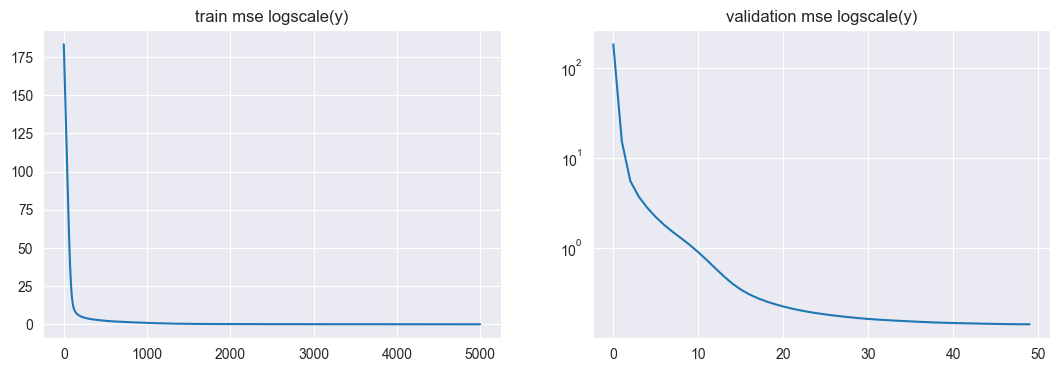

In [41]:
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.title('train mse logscale(y)')
plt.plot(losses)
plt.subplot(122)
plt.title('validation mse logscale(y)')
plt.plot(validation)
plt.yscale('log')